In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/HCCI.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,15.500000,16.200001,15.19,16.030001,16.030001,29300
1,1/3/2013,16.120001,16.260000,15.21,16.040001,16.040001,12900
2,1/4/2013,16.090000,16.780001,15.99,16.370001,16.370001,24300
3,1/7/2013,16.370001,16.450001,15.88,15.880000,15.880000,28400
4,1/8/2013,15.930000,16.469999,15.59,16.180000,16.180000,47800


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 220.690008.3, cost: 0.001664, total money: 10063.570007
epoch: 20, total rewards: 86.090027.3, cost: 0.001216, total money: 9760.730026
epoch: 30, total rewards: 46.080018.3, cost: 0.001189, total money: 10046.080018
epoch: 40, total rewards: 131.959981.3, cost: 0.001717, total money: 9604.469982
epoch: 50, total rewards: 76.850008.3, cost: 0.000182, total money: 9982.120008
epoch: 60, total rewards: 13.669969.3, cost: 0.000639, total money: 9982.109969
epoch: 70, total rewards: 1.579990.3, cost: 0.000333, total money: 9905.999990
epoch: 80, total rewards: 95.039984.3, cost: 0.000414, total money: 10063.469984
epoch: 90, total rewards: -24.510022.3, cost: 0.000331, total money: 9975.489978
epoch: 100, total rewards: 37.989987.3, cost: 0.000324, total money: 10006.429987
epoch: 110, tota

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 16.370001, total balance 9983.629999
day 3, sell 1 unit at price 15.880000, investment -2.993285 %, total balance 9999.509999,
day 9: buy 1 unit at price 14.720000, total balance 9984.789999
day 10, sell 1 unit at price 14.670000, investment -0.339675 %, total balance 9999.459999,
day 30: buy 1 unit at price 15.050000, total balance 9984.409999
day 31, sell 1 unit at price 15.240000, investment 1.262456 %, total balance 9999.649999,
day 32: buy 1 unit at price 15.310000, total balance 9984.339998
day 33, sell 1 unit at price 15.220000, investment -0.587852 %, total balance 9999.559999,
day 34: buy 1 unit at price 15.020000, total balance 9984.539998
day 35, sell 1 unit at price 15.050000, investment 0.199732 %, total balance 9999.589998,
day 38: buy 1 unit at price 14.900000, total balance 9984.689999
day 39, sell 1 unit at price 14.750000, investment -1.006709 %, total balance 9999.439999,
day 68: buy 1 unit at price 14.700000, total balance 9984.739999
day 

day 463: buy 1 unit at price 18.500000, total balance 9981.770002
day 464, sell 1 unit at price 18.379999, investment -0.648653 %, total balance 10000.150001,
day 473: buy 1 unit at price 18.469999, total balance 9981.680001
day 474, sell 1 unit at price 17.600000, investment -4.710335 %, total balance 9999.280002,
day 476: buy 1 unit at price 17.500000, total balance 9981.780002
day 477, sell 1 unit at price 17.570000, investment 0.399998 %, total balance 9999.350001,
day 481: buy 1 unit at price 16.500000, total balance 9982.850001
day 482, sell 1 unit at price 16.610001, investment 0.666670 %, total balance 9999.460002,
day 483: buy 1 unit at price 16.900000, total balance 9982.560002
day 484, sell 1 unit at price 15.190000, investment -10.118344 %, total balance 9997.750002,
day 489: buy 1 unit at price 12.150000, total balance 9985.600002
day 490, sell 1 unit at price 10.900000, investment -10.288066 %, total balance 9996.500002,
day 510: buy 1 unit at price 12.220000, total balan

day 1102, sell 1 unit at price 15.650000, investment -1.261834 %, total balance 9952.280002,
day 1103, sell 1 unit at price 15.850000, investment -1.552795 %, total balance 9968.130002,
day 1104, sell 1 unit at price 16.200001, investment 3.846156 %, total balance 9984.330003,
day 1105, sell 1 unit at price 16.000000, investment 2.564100 %, total balance 10000.330003,
day 1109: buy 1 unit at price 15.250000, total balance 9985.080003
day 1110, sell 1 unit at price 15.250000, investment 0.000000 %, total balance 10000.330003,
day 1111: buy 1 unit at price 15.600000, total balance 9984.730002
day 1112, sell 1 unit at price 15.550000, investment -0.320514 %, total balance 10000.280003,
day 1117: buy 1 unit at price 15.500000, total balance 9984.780003
day 1118, sell 1 unit at price 15.600000, investment 0.645164 %, total balance 10000.380003,
day 1124: buy 1 unit at price 15.050000, total balance 9985.330003
day 1125, sell 1 unit at price 15.000000, investment -0.332227 %, total balance 1

day 1695: buy 1 unit at price 26.180000, total balance 9966.269991
day 1696, sell 1 unit at price 26.270000, investment 0.343774 %, total balance 9992.539991,
day 1700: buy 1 unit at price 25.270000, total balance 9967.269991
day 1703, sell 1 unit at price 25.620001, investment 1.385043 %, total balance 9992.889992,
day 1709: buy 1 unit at price 26.400000, total balance 9966.489992
day 1710, sell 1 unit at price 27.000000, investment 2.272729 %, total balance 9993.489992,
day 1712: buy 1 unit at price 26.820000, total balance 9966.669993
day 1714: buy 1 unit at price 26.000000, total balance 9940.669993
day 1715: buy 1 unit at price 25.740000, total balance 9914.929993
day 1717, sell 1 unit at price 25.990000, investment -3.094705 %, total balance 9940.919993,
day 1718, sell 1 unit at price 26.090000, investment 0.346154 %, total balance 9967.009993,
day 1719, sell 1 unit at price 26.879999, investment 4.428902 %, total balance 9993.889992,
day 1722: buy 1 unit at price 27.959999, tota

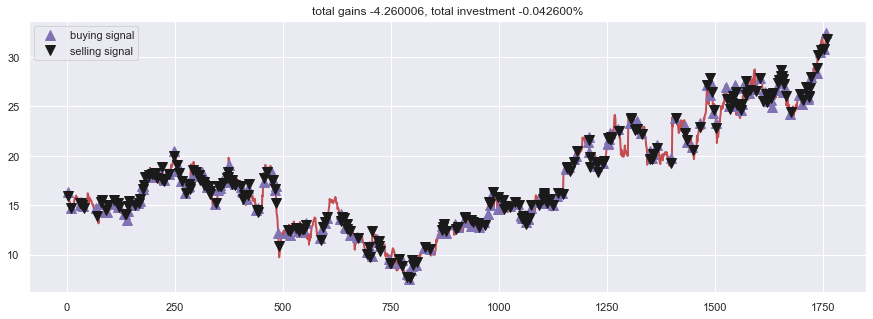

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()